In [ ]:
# ==========================
# 1. Setup & Installations
# ==========================
!pip install timm torch torchvision pillow tqdm

import timm
import torch
import torchvision.transforms as T
from torch import nn
from PIL import Image
import numpy as np
import os
from tqdm import tqdm

In [ ]:
# ==========================
# 2. Load ResNet18 (ImageNet pretrained)
# ==========================
import torchvision.models as models
device = 'cuda' if torch.cuda.is_available() else 'cpu'


model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Identity()   # remove classifier, output 512-D features
model.eval()
model.to(device)

# Transformation for CIFAKE (32x32 -> 224x224 for ResNet)
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet normalization
])


In [ ]:
# ==========================
# 4. Run Extraction for CIFAKE
# ==========================
!pip install kaggle


# Download CIFAKE dataset
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
!unzip cifake-real-and-ai-generated-synthetic-images.zip -d cifake


In [ ]:
# ==========================
# 3. Feature Extraction Function
# ==========================
def extract_features(image_dir, output_file):
    feats = []
    files = sorted(os.listdir(image_dir))
    for fname in tqdm(files[:1000]):  # limit to 1000 images for demo
        path = os.path.join(image_dir, fname)
        img = Image.open(path).convert('RGB')
        x = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            f = model(x).cpu().numpy()[0]
        feats.append(f)
    feats = np.array(feats)
    np.save(output_file, feats)
    print(f"✅ Saved {feats.shape} to {output_file}")


In [ ]:
for i in range(1, 11):
    real_dir = "cifake/train/REAL/cat_" + str(i).zfill(2) 
    fake_dir = "cifake/train/FAKE/cat_" + str(i).zfill(2) 
    # Extract and save
    extract_features(real_dir, "real_features_" + str(i).zfill(2) + ".npy")
    extract_features(fake_dir, "fake_features_" + str(i).zfill(2) + ".npy")


In [1]:
# ==========================
# 1. Install and Import Libraries
# ==========================
!pip install ripser persim matplotlib numpy

from ripser import ripser
from persim import plot_diagrams
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# 2. Load Feature Vectors
# ==========================
# Load the features you previously extracted with ResNet18
m = 5
real_feats_list = np.array([np.load("real_features_" + str(i).zfill(2) +  ".npy") for i in range(1, m+1)])
fake_feats_list = np.array([np.load("fake_features_" + str(i).zfill(2) +  ".npy") for i in range(1, m+1)])

# Combine the three datasets into one

real_feats = np.concatenate(real_feats_list)
fake_feats = np.concatenate(fake_feats_list)


# real_unreduced = np.array([np.load("real_features_unreduced_" + str(i).zfill(2) +  ".npy") for i in range(1, 4)])
# fake_unreduced = np.array([np.load("fake_features_unreduced_" + str(i).zfill(2) +  ".npy") for i in range(1, 4)])

# Optionally, sample to reduce computation
n = 300   # choose 300 points for speed
# real_sample = real_feats[np.random.choice(len(real_feats), size=n, replace=False)]
# fake_sample = fake_feats[np.random.choice(len(fake_feats), size=n, replace=False)]

# print("Real sample shape:", real_sample.shape)
# print("Fake sample shape:", fake_sample.shape)
# print("Real unreduced sample shape:", real_unreduced.shape)
# print("Fake unreduced sample shape:", fake_unreduced.shape)

# ==========================
# 3. Combine Data for Joint Analysis
# ==========================
# X = np.vstack([real_sample, fake_sample])

# Create labels (0 for real, 1 for fake)
# labels = np.array([0]*len(real_sample) + [1]*len(fake_sample))

real_list = np.array([[item.flatten() for item in cat] for cat in real_feats_list]) # only if using unreduced
fake_list = np.array([[item.flatten() for item in cat] for cat in fake_feats_list])
real_list = real_feats_list
fake_list = fake_feats_list


In [2]:
from ripser import ripser
print("Computing real sample:")
rip_real = [ripser(proc, do_cocycles=True, maxdim=1) for proc in real_list]
dgms_real = [element['dgms'] for element in rip_real]
rip_real_total = ripser(real_feats, do_cocycles=True, maxdim=1)
dgms_real_total = rip_real_total['dgms']

Computing real sample:


In [3]:
from ripser import ripser
print("Computing fake sample:")
rip_fake = [ripser(proc, do_cocycles=True, maxdim=1) for proc in fake_list]
dgms_fake = [element['dgms'] for element in rip_fake]
rip_fake_total = ripser(fake_feats, do_cocycles=True, maxdim=1)
dgms_fake_total = rip_fake_total['dgms']

Computing fake sample:


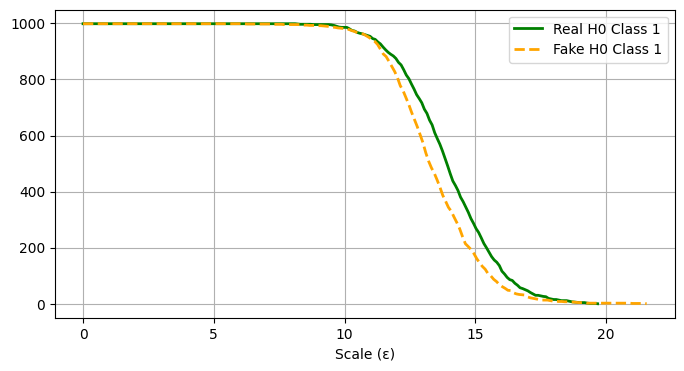

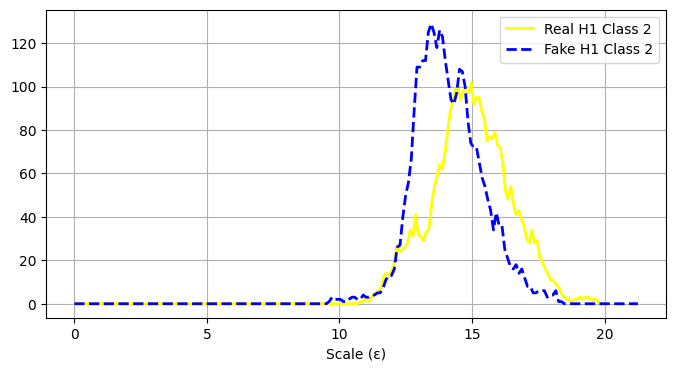

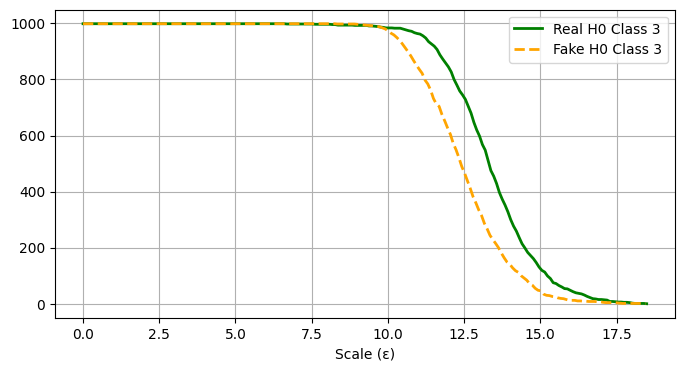

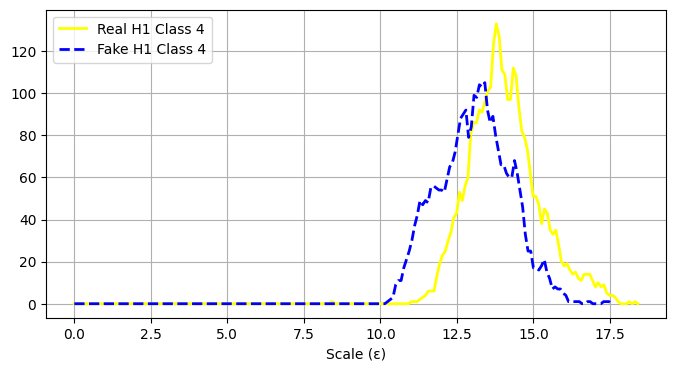

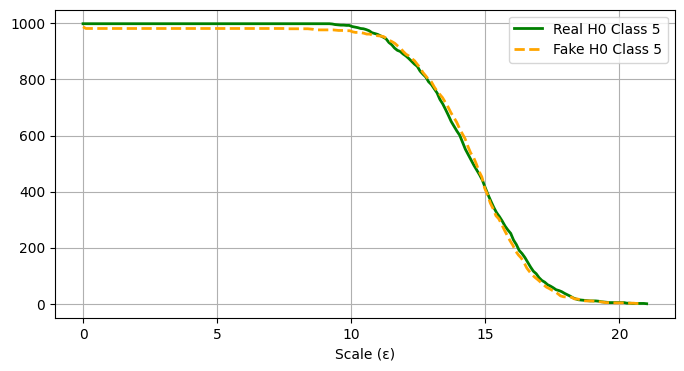

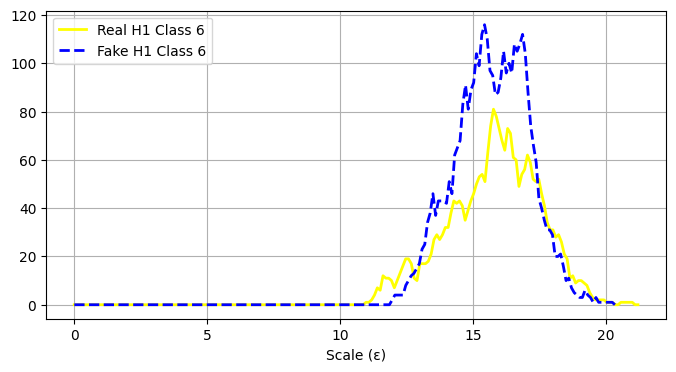

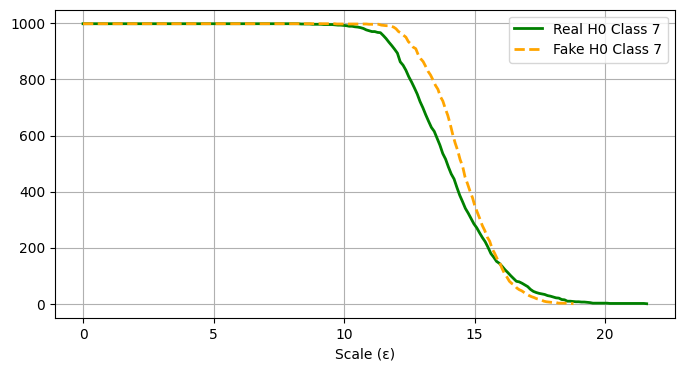

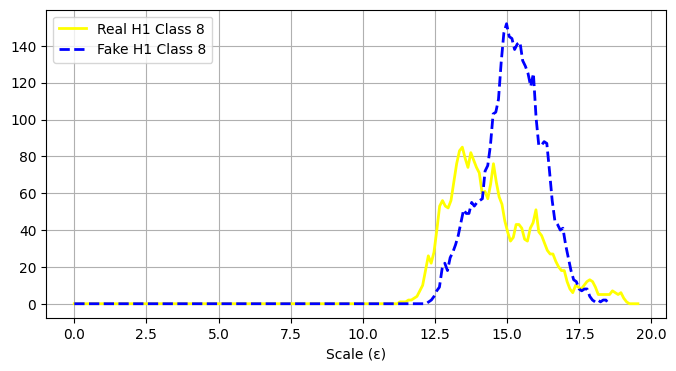

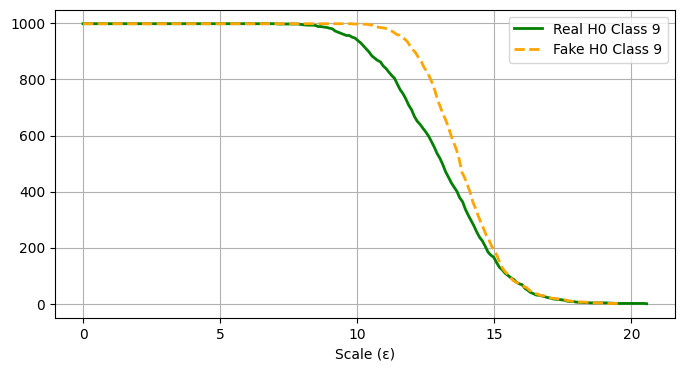

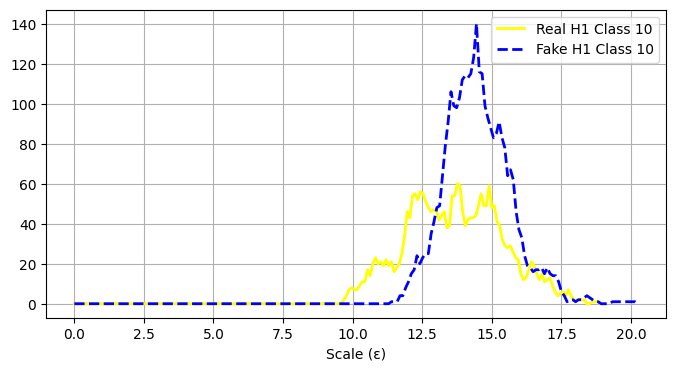

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def compute_betti_curve(diagrams, dim=0, resolution=200):
    """
    Compute Betti curve for a given homology dimension from Ripser diagrams.
    - diagrams: result['dgms'] from ripser
    - dim: 0 (components) or 1 (loops)
    - resolution: number of scale steps
    """
    dgms = diagrams[dim]
    dgms = dgms[np.isfinite(dgms[:, 1])]  # remove infinite deaths

    if len(dgms) == 0:  # handle empty diagrams
        return np.array([0]), np.array([0])

    max_scale = np.max(dgms[:, 1])
    scales = np.linspace(0, max_scale, resolution)
    betti_vals = []

    for s in scales:
        alive = np.sum((dgms[:, 0] <= s) & (dgms[:, 1] > s))
        betti_vals.append(alive)

    return scales, np.array(betti_vals)

# ✅ Compute for both Real and Fake
plot_real_1 = []
plot_fake_1 = []
plot_real_0 = []
plot_fake_0 = []

for item in dgms_real:
    plot_real_1.append(compute_betti_curve(item, dim=1))
    plot_real_0.append(compute_betti_curve(item, dim=0))
for item in dgms_fake:
    plot_fake_1.append(compute_betti_curve(item, dim=1))
    plot_fake_0.append(compute_betti_curve(item, dim=0))
    

plots_1 = zip(plot_real_1, plot_fake_1)
plots_0 = zip(plot_real_0, plot_fake_0)
plots = zip(plots_0, plots_1)
i=0
for item in plots:
    i += 1
    plt.figure(figsize=(8,4))
    plt.plot(item[0][0][0], item[0][0][1], lw=2,            label="Real H0 Class "+ str(i), color="green")
    plt.plot(item[0][1][0], item[0][1][1], lw=2, ls="--",   label="Fake H0 Class "+ str(i), color="orange")
    plt.xlabel("Scale (ε)")
    plt.legend()
    plt.grid(True)
    plt.show()
    i += 1
    plt.figure(figsize=(8,4))
    plt.plot(item[1][0][0], item[1][0][1], lw=2,            label="Real H1 Class "+ str(i), color="yellow")
    plt.plot(item[1][1][0], item[1][1][1], lw=2, ls="--",   label="Fake H1 Class "+ str(i), color="blue")
    plt.xlabel("Scale (ε)")
    plt.legend()
    plt.grid(True)
    plt.show()
    

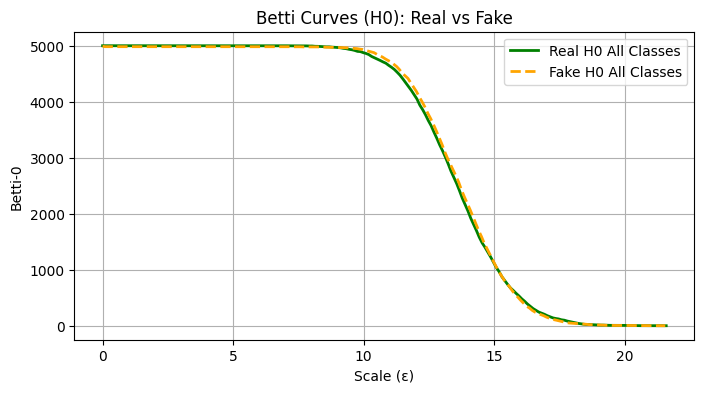

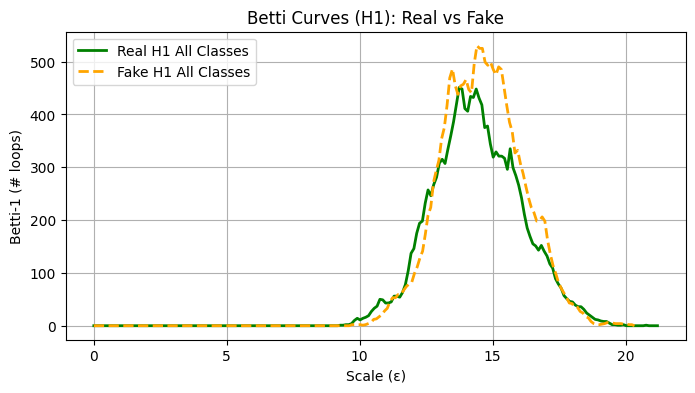

In [5]:

sc_r0, br0 = compute_betti_curve(dgms_real_total, dim=0)
sc_f0, bf0 = compute_betti_curve(dgms_fake_total, dim=0)
sc_r1, br1 = compute_betti_curve(dgms_real_total, dim=1)
sc_f1, bf1 = compute_betti_curve(dgms_fake_total, dim=1)

plt.figure(figsize=(8,4))
plt.plot(sc_r0, br0, lw=2, label="Real H0 All Classes", color="green")
plt.plot(sc_f0, bf0, lw=2, ls="--", label="Fake H0 All Classes", color="orange")
plt.xlabel("Scale (ε)")
plt.ylabel("Betti-0")
plt.title("Betti Curves (H0): Real vs Fake")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(sc_r1, br1, lw=2, label="Real H1 All Classes", color="green")
plt.plot(sc_f1, bf1, lw=2, ls="--", label="Fake H1 All Classes", color="orange")
plt.xlabel("Scale (ε)")
plt.ylabel("Betti-1 (# loops)")
plt.title("Betti Curves (H1): Real vs Fake")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:



sc_r1_1, br1_1 = compute_betti_curve(dgms_real[0], dim=2)
sc_f1_1, bf1_1 = compute_betti_curve(dgms_fake[0], dim=2)
sc_r1_2, br1_2 = compute_betti_curve(dgms_real[1], dim=2)
sc_f1_2, bf1_2 = compute_betti_curve(dgms_fake[1], dim=2)
sc_r1_3, br1_3 = compute_betti_curve(dgms_real[2], dim=2)
sc_f1_3, bf1_3 = compute_betti_curve(dgms_fake[2], dim=2)
# ✅ Plot H2 (Loops)

plt.figure(figsize=(8,4))
plt.plot(sc_r1_1, br1_1, lw=2, label="Real H2", color="green")
plt.plot(sc_f1_1, bf1_1, lw=2, ls="--", label="Fake H2", color="orange")
plt.xlabel("Scale (ε)")
plt.ylabel("Betti-1 (# loops)")
plt.title("Betti Curves (H2): Real vs Fake")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(sc_r1_2, br1_2, lw=2, label="Real H2", color="green")
plt.plot(sc_f1_2, bf1_2, lw=2, ls="--", label="Fake H2", color="orange")
plt.xlabel("Scale (ε)")
plt.ylabel("Betti-1 (# loops)")
plt.title("Betti Curves (H2): Real vs Fake")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(sc_r1_3, br1_3, lw=2, label="Real H2", color="green")
plt.plot(sc_f1_3, bf1_3, lw=2, ls="--", label="Fake H2", color="orange")
plt.xlabel("Scale (ε)")
plt.ylabel("Betti-1 (# loops)")
plt.title("Betti Curves (H2): Real vs Fake")
plt.legend()
plt.grid(True)
plt.show()

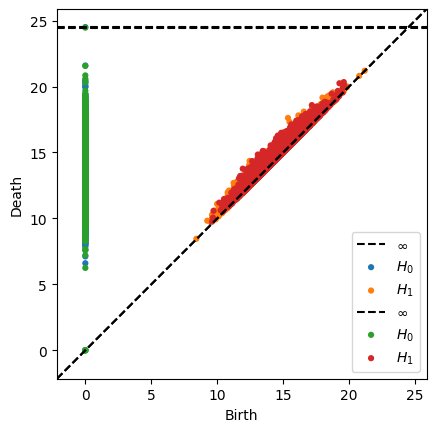

In [7]:
plot_diagrams(dgms_real_total)
plot_diagrams(dgms_fake_total)